In [1]:
import json
from collections import defaultdict
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("d1shs0ap/cognitive-behaviors-Llama-3.2-3B")

In [18]:
def get_lengths(rollouts):
    correct_lengths_by_difficulty = defaultdict(list)
    incorrect_lengths_by_difficulty = defaultdict(list)

    for i in range(len(rollouts) // 8):
        difficulty = rollouts[i]['ref_score']

        correct_length = 0
        incorrect_length = 0
        correct_count = 0
        incorrect_count = 0
        
        for j in range(8):
            row = rollouts[i * 8 + j]

            if row['score'] == 0:
                incorrect_length += row['length']
                incorrect_count += 1
            elif row['score'] == 1:
                correct_length += row['length']
                correct_count += 1
        
        correct_lengths_by_difficulty[difficulty].append(correct_length / correct_count if correct_count > 0 else 0)
        incorrect_lengths_by_difficulty[difficulty].append(incorrect_length / incorrect_count if incorrect_count > 0 else 0)
    
    return correct_lengths_by_difficulty, incorrect_lengths_by_difficulty

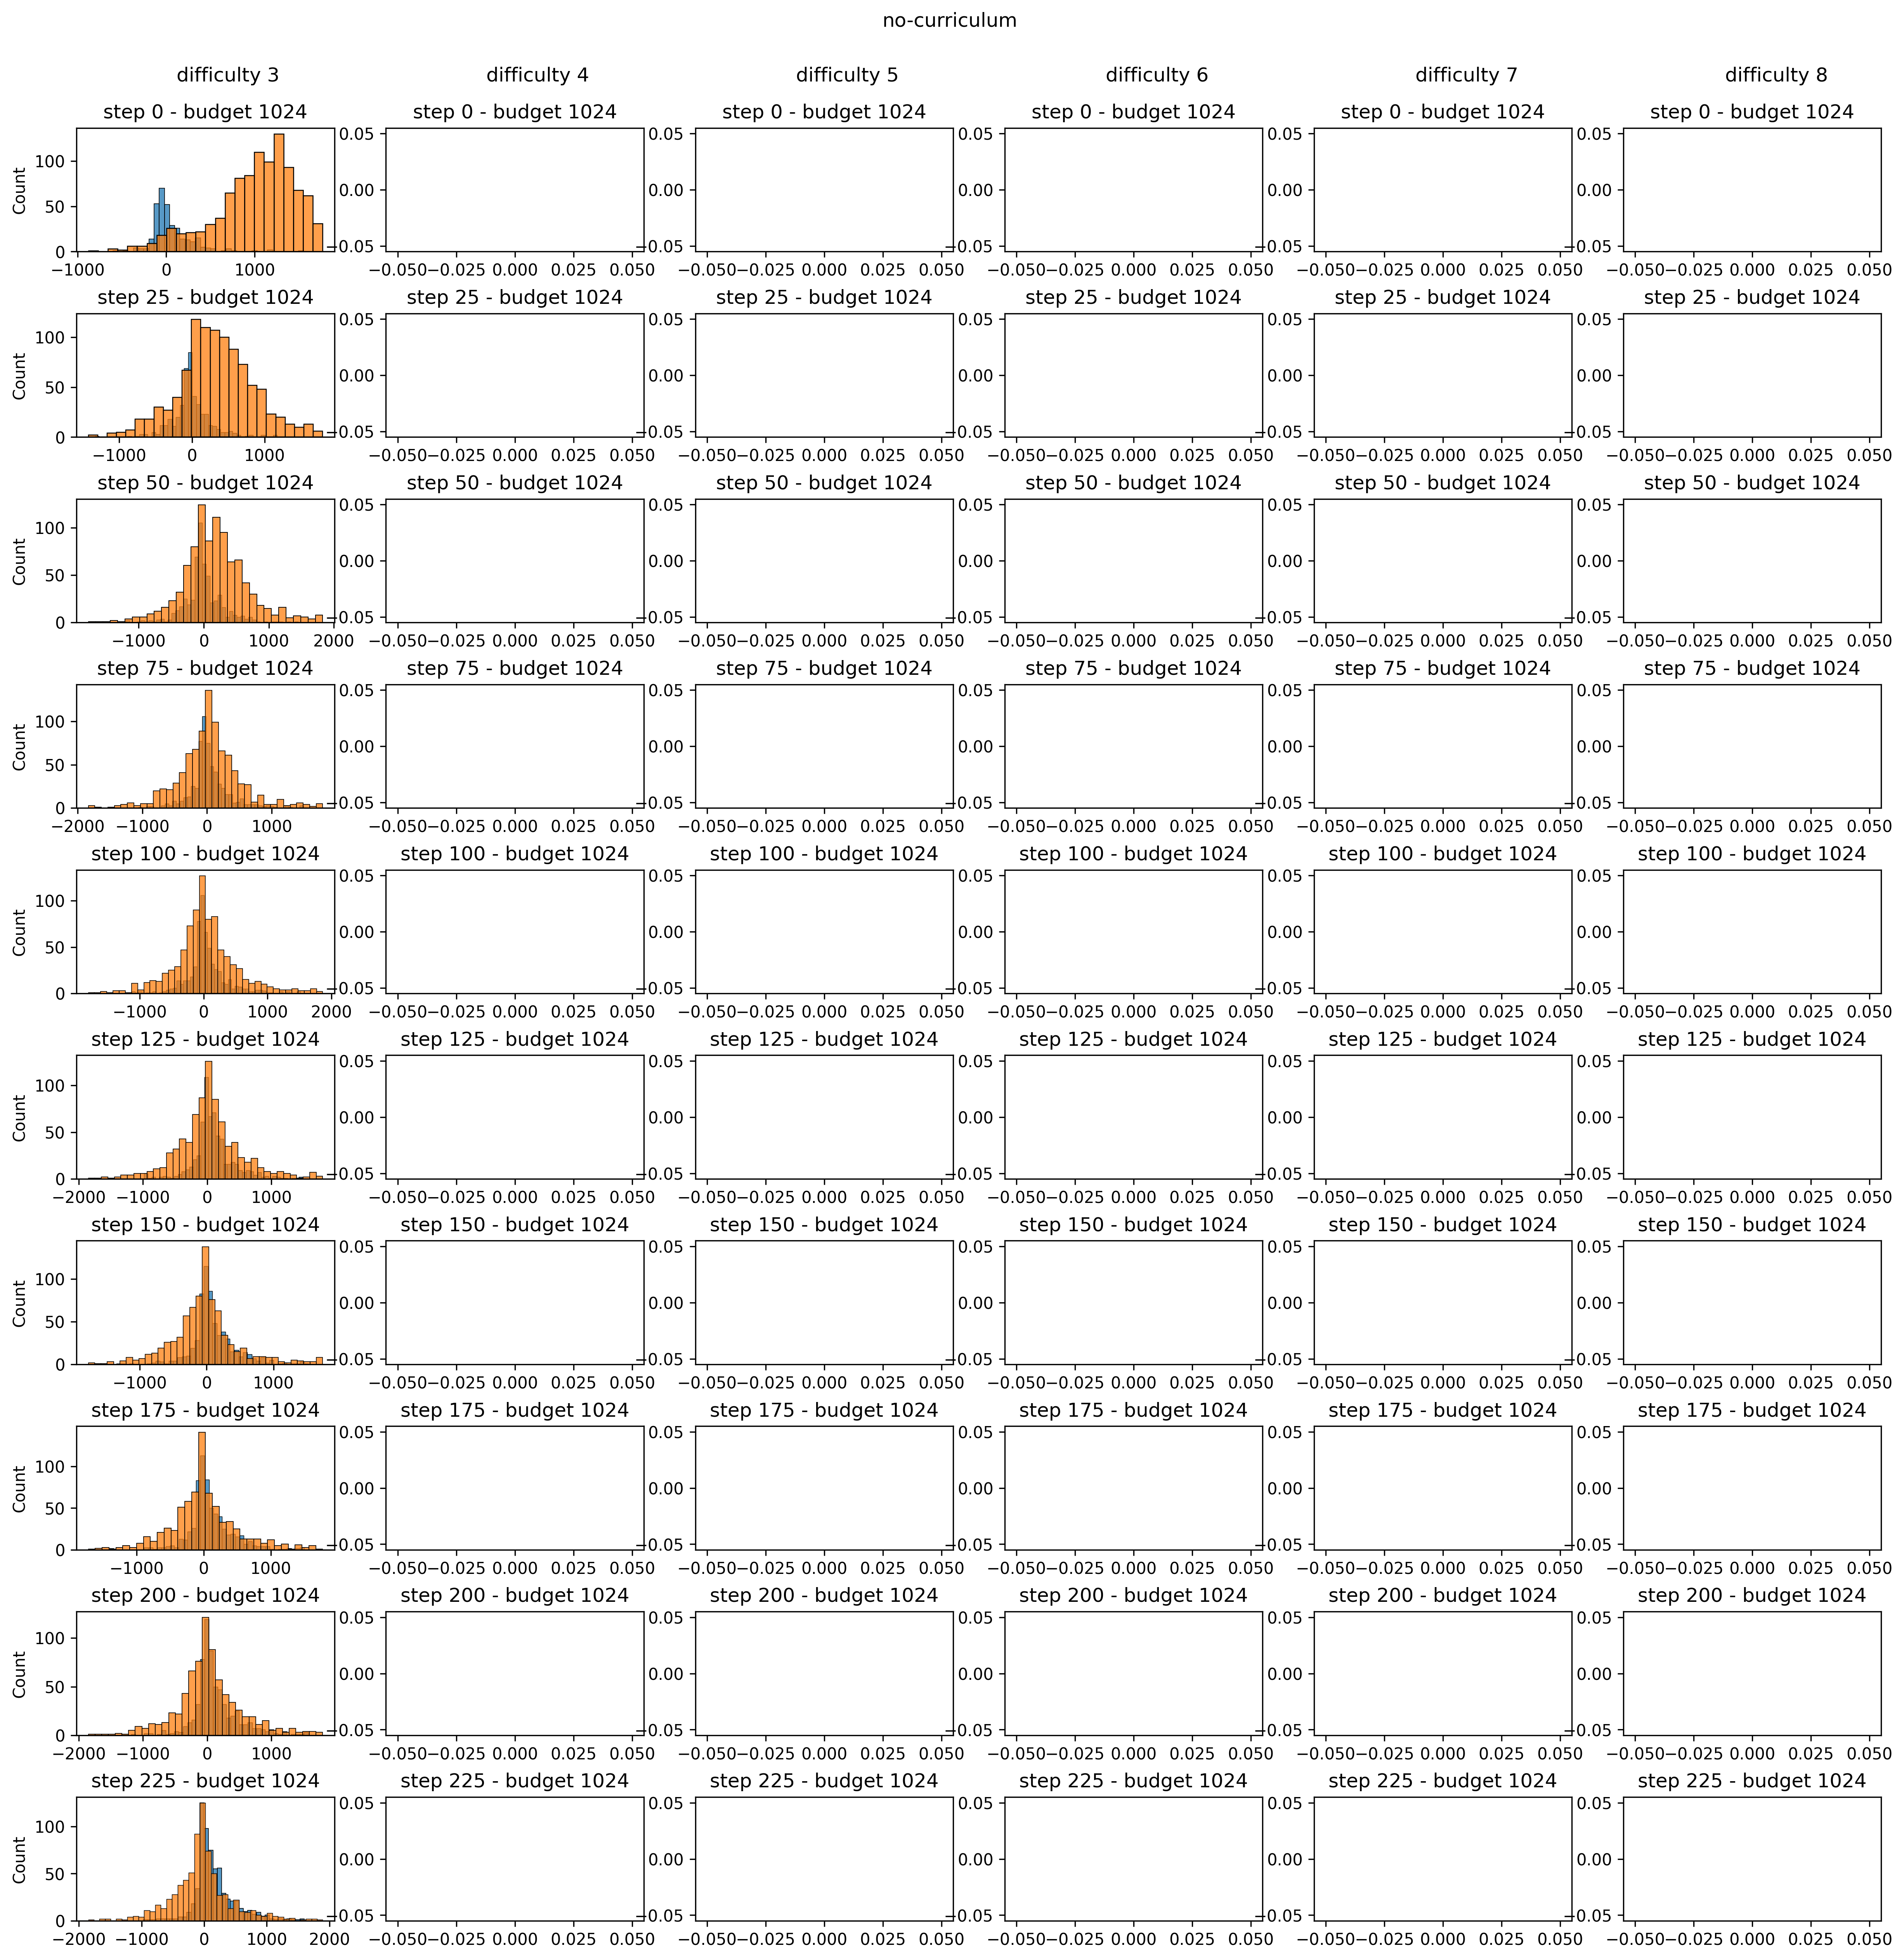

<Figure size 640x480 with 0 Axes>

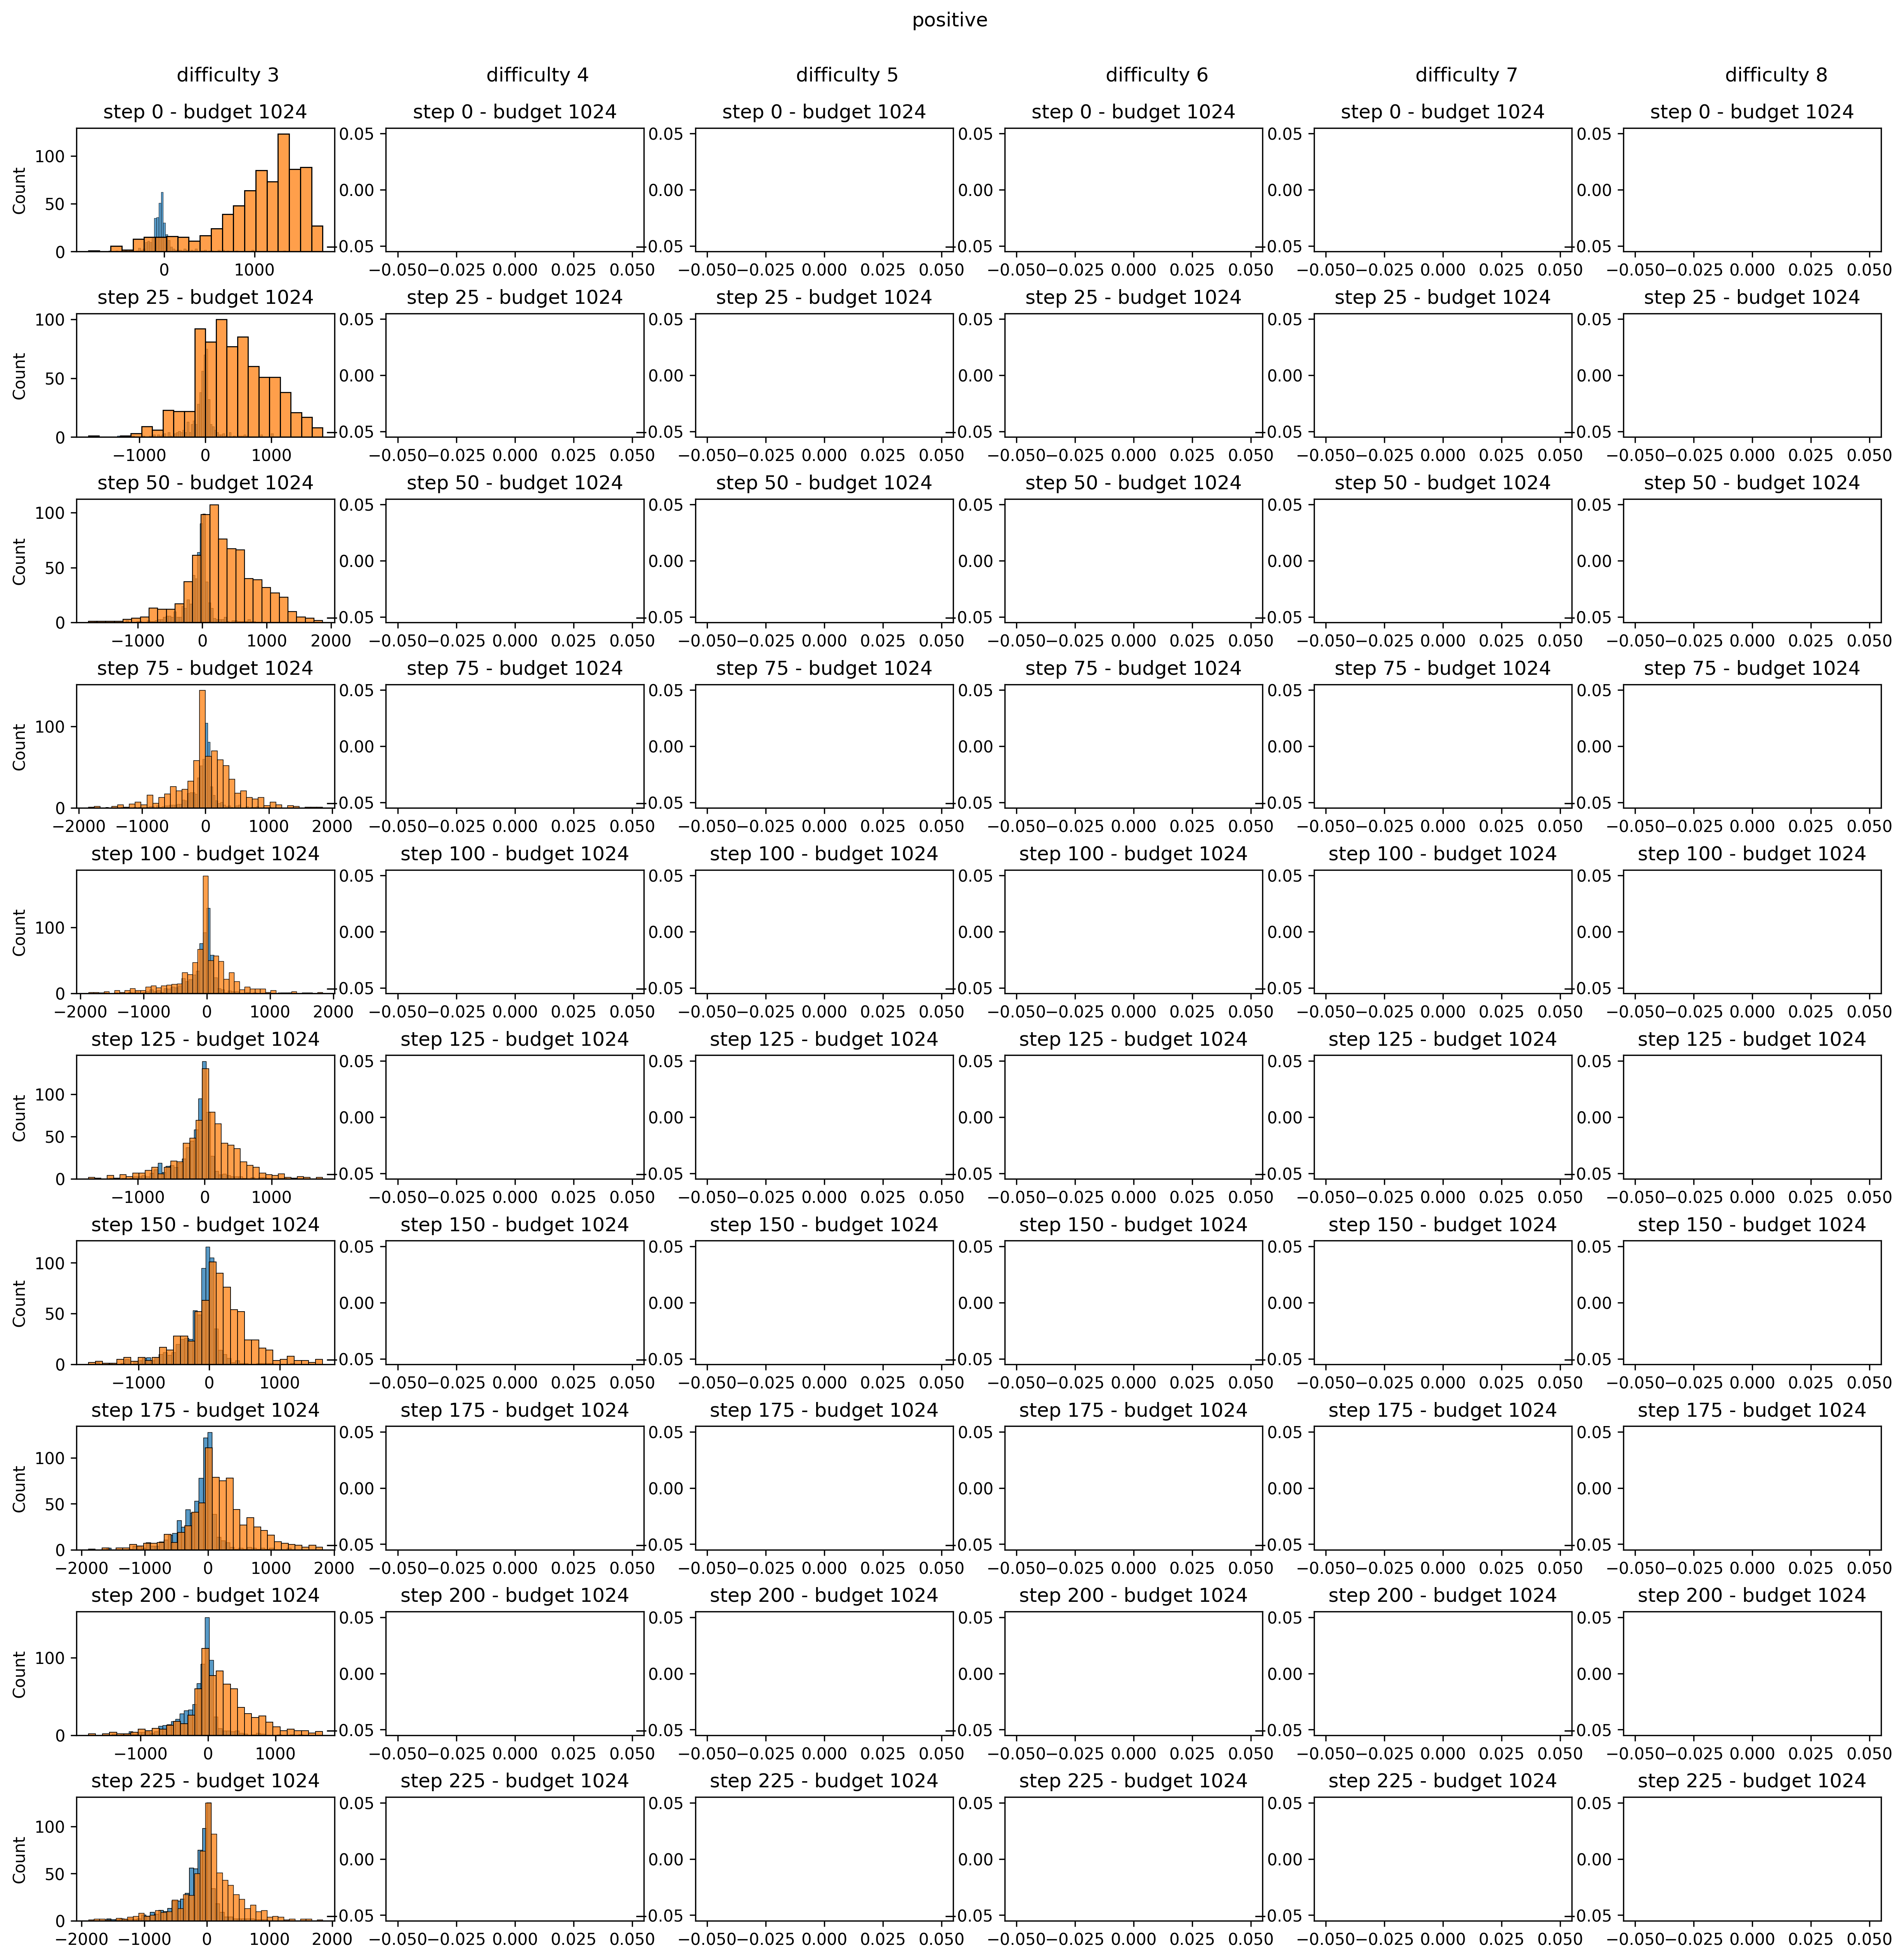

<Figure size 640x480 with 0 Axes>

In [23]:
def steps_to_budget(folder, steps):
    if folder == 'difficulty-curriculum' or folder == 'no-curriculum' or folder == 'positive':
        return 1024
    
    elif folder == 'both-curriculum' or folder == 'length-curriculum':
        if steps < 100:
            return 256
        elif steps < 150:
            return 512
        else:
            return 1024
    
    else:
        raise ValueError(f"Unknown folder: {folder}")


for folder in ['no-curriculum', 'positive']:
    fig, ax = plt.subplots(nrows=10, ncols=6, figsize=(20, 20), dpi=300)

    base_rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/difficulty-curriculum/0_extrapolation_rollouts.json"
    with open(base_rollouts_file, 'r') as f:
        base_rollouts = json.load(f)
    
    base_correct_lengths_by_difficulty, base_incorrect_lengths_by_difficulty = get_lengths(rollouts)
    
    for i, step in enumerate(range(0, 225 + 1, 25)):
        rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/{folder}/{step}_extrapolation_rollouts.json"
        with open(rollouts_file, 'r') as f:
            rollouts = json.load(f)
        
        correct_lengths_by_difficulty, incorrect_lengths_by_difficulty = get_lengths(rollouts)
        for j, difficulty in enumerate(range(3, 9)):

            correct_diffs = []
            for length, base_length in zip(base_correct_lengths_by_difficulty[difficulty], correct_lengths_by_difficulty[difficulty]):
                if length == 0 or base_length == 0:
                    continue
                correct_diffs.append(length - base_length)

            incorrect_diffs = []
            for length, base_length in zip(base_incorrect_lengths_by_difficulty[difficulty], incorrect_lengths_by_difficulty[difficulty]):
                if length == 0 or base_length == 0:
                    continue
                incorrect_diffs.append(length - base_length)

            sns.histplot(x=correct_diffs, ax=ax[i][j], label="correct")
            sns.histplot(x=incorrect_diffs, ax=ax[i][j], label="incorrect")
            if i == 0:
                fig.text(0.19 + 0.133 * j, 0.9, f"difficulty {difficulty}", ha='center', fontsize=12)
            ax[i][j].set_title(f"step {step} - budget {steps_to_budget(folder, step)}")

    plt.suptitle(folder, y=0.93)

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()
    plt.clf()

In [9]:
rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/hard-both-curriculum/100_rollouts.json"
with open(rollouts_file, 'r') as f:
    rollouts = json.load(f)

In [14]:
for row in rollouts:
    if row['score'] == 1 and row['ref_score'] == 8:
        print(row['output'])
        break

<think>
Let me try to find a way to get to 0.
First, let's try to get close to 0 with the larger numbers:
70-65 = 5 (getting closer to 0)
53-42 = 11 (also getting closer to 0)

Let's try a different approach:
43-13 = 30
30+6 = 36
36+0 = 36 (still not 0)

Let's try:
53-70 = -17
-17+65 = 48
48-43 = 5
5+42 = 47
47+6 = 53
53-13 = 40
40-0 = 40 (still not 0)

Let me try one more approach:
70-65 = 5
5+53 = 58
58-43 = 15
15+42 = 57
57-13 = 44
44-6 = 38
38+0 = 38 (still not 0)

Let's try:
53-42 = 11
11+70 = 81
81-65 = 16
16+43 = 59
59-13 = 46
46-6 = 40
40-0 = 40 (still not 0)

Final attempt:
70-65 = 5
5+53 = 58
58-43 = 15
15+42 = 57
57-6 = 51
51-13 = 38
38+0 = 38 (still not 0)

One last try:
53-42 = 11
11+6 = 17
17+70 = 87
87-65 = 22
22-43 = -21
-21+0 = -21
-21+13 = -8 (moving away from 0)

Aha! Let's try:
53-70 = -17
-17+65 = 48
48-43 = 5
5+42 = 47
47*0 = 0 (This works!)
47*0+6 = 282
282-13 = 269
269-0 = 269 (still not 0)

Final successful attempt:
70-65 = 5
5+43 = 48
48-53 = -5
-5+42 = 37
37+

In [15]:
rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/hard-length-curriculum/100_rollouts.json"
with open(rollouts_file, 'r') as f:
    rollouts = json.load(f)

In [16]:
for row in rollouts:
    if row['score'] == 1 and row['ref_score'] == 8:
        print(row['output'])
        break

<think>
Let me try to find a path to 298.
First, let's try to get close to 298 with some operations:
96 + 98 = 194, that's close to 298
194 + 63 = 257, getting closer
257 + 69 = 326, too high

Let's try a different approach:
96 + 98 = 194
194 + 69 = 263
263 + 63 = 326
326 - 54 = 272
272 + 43 = 315
315 - 42 = 273
273 + 25 = 298
This works!
</think>
<answer> (96 + 98) + 69 + 63 - 54 + 43 - 42 + 25 </answer>
